This file contains the work to generate core users and feeding it to IDCF codebase Movielens-1m dataset.
- greater than 30 interactions are taken into.
- Less than 30 interations are taken into test set
- some x% of coreusers are choosen as training set
- coreusers are calculated using CUR decomposition and R matrix is taken as coreuser.
- always the results are tested on test set.

In [36]:
from fileinput import filename
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import svds
import random 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import scipy.stats as ss
import pickle
from sklearn.utils.extmath import randomized_svd

In [37]:
def ReadData():
    ml1m_dir = 'data/ratings.dat'
    ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')
    unique_uid = np.unique(np.array(ml1m_rating['uid'].tolist()))
    unique_mid = np.unique(np.array(ml1m_rating['mid'].tolist()))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    mid_dict = dict([(y,x) for x,y in enumerate(unique_mid)])
    print('DICTIONARY PREPARED:')

    # init user item dictionary:
    
    uid_list = ml1m_rating['uid'].tolist()
    uid_list_len = len(uid_list)
    mid_list = ml1m_rating['mid'].tolist()
    mid_list_len = len(mid_list)
    rating_list = ml1m_rating['rating'].tolist()
    user_item_dict = {x:set() for x in range(len(unique_uid))}
    item_user_dict = {x:set() for x in range(len(unique_mid))}
    for i in range(uid_list_len):
        uid_list[i] = uid_dict[uid_list[i]]
        mid_list[i] = mid_dict[mid_list[i]]
        # rating_list[i] = 1 # comment this line if you want to activate explicit ratings
        user_item_dict[uid_list[i]].add(mid_list[i])
        item_user_dict[mid_list[i]].add(uid_list[i])
    tmp_df = pd.DataFrame({"uid":uid_list, "mid":mid_list, "ratings":rating_list})
    v = tmp_df.uid.value_counts()
    df = tmp_df[tmp_df.uid.isin(v.index[v.gt(30)])]
### code to store less than 30 interactions:
    df_less_30 = tmp_df[tmp_df.uid.isin(v.index[v.le(30)])]
    return df, df_less_30, len(np.unique(mid_list)), len(unique_uid)

In [38]:
threshold = 30 #split the users into test and train by threshold number of interactions. if greater than threshold then all interactions of that user goes into train set.
df_gt_30, df_le_30, unique_mids, unique_uids = ReadData()
print("GREATER THAN 30:\n", df_gt_30)
print("LESS THAN 30: \n", df_le_30)
print(len(df_gt_30))
print(len(df_le_30))
print("UNIQUE MIDS: ", unique_mids)
print("UNIQUE UIDS: ", unique_uids)

DICTIONARY PREPARED:
GREATER THAN 30:
           uid   mid  ratings
0           0  1104        5
1           0   639        3
2           0   853        3
3           0  3177        4
4           0  2162        5
...       ...   ...      ...
1000204  6039  1019        1
1000205  6039  1022        5
1000206  6039   548        5
1000207  6039  1024        4
1000208  6039  1025        4

[980300 rows x 3 columns]
LESS THAN 30: 
          uid   mid  ratings
233        3  3235        5
234        3  1120        3
235        3  2743        4
236        3  1124        4
237        3   971        4
...      ...   ...      ...
999740  6037  1288        2
999741  6037  2495        1
999742  6037  2511        3
999743  6037  3165        3
999744  6037  1007        5

[19909 rows x 3 columns]
980300
19909
UNIQUE MIDS:  3706
UNIQUE UIDS:  6040


In [39]:
support_test_df = df_gt_30.groupby("uid").tail(1)
# print(len(df_gt_30))
support_train_df = df_gt_30.drop(df_gt_30.groupby('uid').tail(1).index, inplace=False)
# print("#TEST INSTANCES: " ,len(support_test_df))
# print("#TRAIN INSTANCES: " ,len(support_train_df))
assert(len(df_gt_30)== len(support_test_df) + len(support_train_df))
# print(len(test_df))
# print(len(train_df))
query_test_df = df_le_30.groupby("uid").tail(1)
query_train_df = df_le_30.drop(df_le_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_le_30)== len(query_test_df) + len(query_train_df))
dic_support_train_df_uid_mapping = dict([(y,x) for x,y in enumerate(np.unique(support_train_df['uid']))])
dic_support_train_df_uid_rmapping = dict([(x,y) for x,y in enumerate(np.unique(support_train_df['uid']))])
### no need for mid mapping

uid_of_train_df = support_train_df['uid'].tolist()
for i in range(len(uid_of_train_df)):
    uid_of_train_df[i] = dic_support_train_df_uid_mapping[uid_of_train_df[i]]
# for index, row in train_df.iterrows():
#     train_df['uid'][index] = dic_train_df_uid_mapping[train_df['uid'][index]]
core_user_ko_input_train_df = pd.DataFrame({'uid':uid_of_train_df, 'mid':support_train_df['mid'], 'ratings':support_train_df['ratings']})

In [40]:
train_ui_dic = {}    
for user in range(unique_uids):
    train_ui_dic[user] = []
for index,row in support_train_df.iterrows():
        train_ui_dic[row['uid']].append(row['mid'])

- utility functions for CUR coreusers.

In [41]:
MAX_MID = 27277 + 1
def select_cols(mat, k, dup=False):
    # prob 1d array of probabilities of all columns
    prob = mat.T.dot(mat)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis = 0)
    prob = prob/denom

    C = np.zeros((mat.shape[0], k))
    ind_cols = np.arange(0, prob.size)
    c_ind = []
    i = 0
    while(i < k):
        rand_sel = np.random.choice(ind_cols, 1, p=prob)
        if rand_sel in c_ind:
            continue
        c_ind.append(rand_sel[0])
        C[:, i] = mat[:, rand_sel[0]]
        i += 1
        # C[:, i] = C[:, i]/np.sqrt(k*prob[rand_sel[0]])

    return C, c_ind

def select_rows(mat, k, dup=False):

    prob = mat.dot(mat.T)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis=0)
    prob = prob/denom
    print(prob)
    r = np.zeros((k, mat.shape[1]))
    ind_rows = np.arange(0, prob.size)
    r_ind = []
    i = 0
    while(i < k):
        # print(ind_rows)
        rand_sel = np.random.choice(ind_rows, 1, p=prob)
        if rand_sel in r_ind:
            continue
        r_ind.append(rand_sel[0])
        r[i, :] = mat[rand_sel[0], :]
        i += 1
        # r[i, :] = r[i, :]/np.sqrt(k*prob[rand_sel[0]])
    r_ind = np.array(r_ind)
    return r, r_ind

# def matIntersection(mat, c_ind, r_ind):
    
#     W = np.zeros((len(r_ind), len(c_ind)))
#     for i in range(len(r_ind)):
#         W[i] = mat[r_ind[i], c_ind]
    
#     return W

# def pseudoInverse(W):
#     # U = WP (W+)

#     # W = X.Z.YT
#     X, Z, YT = np.linalg.svd(W)
    
#     # W+ = Y.Z+.XT
#     XT = X.T
#     Y = YT.T
#     # Z+ = reciprocal(Z)
#     ZP = np.reciprocal(Z)
#     ZP = sp.spdiags(ZP, 0, ZP.size, ZP.size)
#     ZP = ZP@ZP
    
#     # W+ = Y.Z+.XT
#     WP = Y@ZP
#     WP = WP@XT

#     return WP

In [42]:
def CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    C, c_ind = select_cols(mat, int(u_len * 0.10)) ## getting 20% core users
    r, r_ind= select_rows(mat, int(u_len * 0.10))
    print("r", r)
    print("r_ind len", len(r_ind))

    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(r_ind))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return cur_coreusers

- cur decomposition from paper (https://www.pnas.org/doi/10.1073/pnas.0803205106)

In [55]:
class CUR():
    def __init__(self, k, eps, it=None, truncated=False):
        self.k = k
        print("K IS :", self.k)
        self.eps = eps
        self.trunc = truncated 
        self.c = k * np.log(k) / eps**2 #expectation number of sampled columns
        self.C, self.U, self.R = None, None, None #matrices of decomposition
        self.pi_col, self.pi_row = None, None #leverage scores of corresponding columns/rows
        self.col_indices = None
        self.row_indices = None
    
    def column_select(self, A):
        n = A.shape[1]
        A = np.array(A.copy())
        if self.trunc:
            _, _, v_k = randomized_svd(A, self.k) #for very big matrices
        else:
            _, _, vh = np.linalg.svd(A, full_matrices=False)
            v_k = vh[0:self.k, :]
        
        pi = 1 / self.k * np.sum(v_k**2, axis=0)
        c_index = [np.random.choice(2, 
                        p=[1 - min(1, self.c * pi[i]), min(1, self.c * pi[i])]) for i in range(n)
                  ]
        c_index = np.nonzero(c_index)[0]
        print(len(c_index))
        C = A[:, c_index]
        return C, c_index, pi

    def run_CUR(self, A):
        A = np.array(A.copy())
        # self.C, self.col_indices, self.pi_col = self.column_select(A)
        self.R, self.row_indices, self.pi_row = self.column_select(A.T)
        # self.U = np.linalg.pinv(self.C) @ A @ np.linalg.pinv(self.R.T)
        return self.row_indices
def OPTIMAL_CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    cur = CUR(k=int(u_len * 0.10), eps=0.5,)
    # ids = np.argsort(cur.pi_col)[::-1][:5]
    cur.run_CUR(mat)
    cur_coreusers_idx = np.argsort(cur.pi_row)[::-1][:int(u_len * 0.10)]
    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(cur_coreusers_idx))]
    # print(len(cur_coreusers))
    return cur_coreusers

In [56]:
core_users = OPTIMAL_CUR_ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
support_user_list = np.unique(core_users['uid'])
# print("CORE USERS:" ,core_users)

USER LEN: 5231
MOVIE LEN: 3706
USER ITEM MATRIX: 
 [[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]
MAT: [[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]
(5231, 3706)
K IS : 523
4858


In [57]:
print((len(support_user_list)))

523


In [33]:
print(len(support_user_list))
len(np.unique(uid_of_train_df))
# print()

523


5231

In [21]:
core_users_index_list = core_users.index.to_list()
# non_core_user_index = (train_df.index.difference(core_users.index))
# non_core_user_index = non_core_user_index.tolist()

core_users_df = support_train_df.loc[core_users_index_list]
# non_core_user_df = train_df.loc[non_core_user_index]
# print("NON CORE USERS:" ,non_core_user_df)
print("CORE USERS:" ,core_users)

CORE USERS:            uid   mid  ratings
0            0     1        1
19          16   470        1
21          18   506        1
46          41   996        1
50          45  1079        1
...        ...   ...      ...
1500194  48452  3490        1
1500195  48452  6131        1
1500196  48452  4637        1
1500197  48452  3771        1
1500198  48452  6172        1

[140528 rows x 3 columns]


In [22]:
# print("TEST DF CONTAINS TEST FOR CORE AND NON CORE ENTITIES:\n" ,test_df)
# print(core_users['uid'])
unique_uids_in_support_trian = np.unique(np.array(core_users_df['uid']))
unique_uids_in_query_trian = np.unique(query_train_df['uid'])
print(len(unique_uids_in_support_trian))
support_test_df = support_test_df.loc[support_test_df['uid'].isin(unique_uids_in_support_trian)]
print("SUPPORT TEST DF:" ,support_test_df)
query_test_df = query_test_df
print("QUERY TEST DF:\n", query_test_df)

4847
SUPPORT TEST DF:            uid   mid  ratings
55210        0    12        1
55686       19   478        1
55734       21   413        1
56328       46  1006        1
56445       50  1097        1
...        ...   ...      ...
1498974  55115  6585        1
1499087  55120  1817        1
1499448  55136  7316        1
1499646  55143   633        1
1500199  55163  2131        1

[4847 rows x 3 columns]
QUERY TEST DF:
            uid   mid  ratings
55229        1    34        1
55416        9   219        1
55435       10   237        1
55903       29   682        1
55970       32   740        1
...        ...   ...      ...
1499328  55131   856        1
1499623  55142  5358        1
1500406  55170  2066        1
1500502  55174  4130        1
1500727  55183  4905        1

[6714 rows x 3 columns]


In [23]:
support_train = []
for index,row in core_users_df.iterrows():
    support_train.append([row['uid'], row['mid'], row['ratings']])
query_train = []
for index, row in query_train_df.iterrows():
    query_train.append([row['uid'], row['mid'], row['ratings']])
support_test = []
for index, row in support_test_df.iterrows():
    support_test.append([row['uid'], row['mid'], row['ratings']])
query_test = []
for index, row in query_test_df.iterrows():
    query_test.append([row['uid'], row['mid'], row['ratings']])
user_his_dic = {}
for u in train_ui_dic.keys():
    user_his_dic[u] = train_ui_dic[u]
user_supp_list = np.unique(core_users_df['uid']).tolist()

In [24]:
import pickle
with open("cur_20_support_as_core.pkl", "wb") as f:
    pickle.dump(support_train, f)
    pickle.dump(query_train, f)
    pickle.dump(support_test, f)
    pickle.dump(query_test, f)
    pickle.dump(user_supp_list, f)
    pickle.dump(user_his_dic, f)

- 20% cur coreusers into IDCF

In [43]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 350454/19100
test set size: support/query 1046/809
Epoch 0 Step 326: Train 2.3744 Reg: 0.5801
Test: 0.8841 MAE: 0.7485 RMSE: 0.9403
Val: 0.8295 MAE: 0.7204 RMSE: 0.9108
Epoch 1 Step 652: Train 0.8227 Reg: 0.4742
Test: 0.8720 MAE: 0.7455 RMSE: 0.9338
Val: 0.8162 MAE: 0.7159 RMSE: 0.9034
Epoch 2 Step 978: Train 0.8162 Reg: 0.3923
Test: 0.8831 MAE: 0.7473 RMSE: 0.9397
Val: 0.8117 MAE: 0.7120 RMSE: 0.9010
Epoch 3 Step 1304: Train 0.8133 Reg: 0.3389
Test: 0.8575 MAE: 0.7363 RMSE: 0.9260
Val: 0.8067 MAE: 0.7109 RMSE: 0.8982
Epoch 4 Step 1630: Train 0.8103 Reg: 0.3066
Test: 0.8620 MAE: 0.7369 RMSE: 0.9284
Val: 0.8071 MAE: 0.7100 RMSE: 0.8984
Epoch 5 Step 1956: Train 0.8064 Reg: 0.2876
Test: 0.8742 MAE: 0.7433 RMSE: 0.9350
Val: 0.8034 MAE: 0.7067 RMSE: 0.8963
Epoch 6 Step 2282: Train 0.8025 Reg: 0.2758
Test: 0.8604 MAE: 0.7388 RMSE: 0.9276
Val: 0.7992 MAE: 0.7075 RMSE: 0.8940
Ep

- 10% CUR coueusers to IDCF

In [42]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 181085/19100
test set size: support/query 523/809
Epoch 0 Step 168: Train 3.6543 Reg: 0.5106
Test: 0.9035 MAE: 0.7842 RMSE: 0.9506
Val: 0.8944 MAE: 0.7500 RMSE: 0.9457
Epoch 1 Step 336: Train 0.8412 Reg: 0.4776
Test: 0.8339 MAE: 0.7370 RMSE: 0.9132
Val: 0.8397 MAE: 0.7243 RMSE: 0.9164
Epoch 2 Step 504: Train 0.8179 Reg: 0.4384
Test: 0.8199 MAE: 0.7289 RMSE: 0.9055
Val: 0.8333 MAE: 0.7230 RMSE: 0.9129
Epoch 3 Step 672: Train 0.8120 Reg: 0.4062
Test: 0.8104 MAE: 0.7268 RMSE: 0.9002
Val: 0.8261 MAE: 0.7184 RMSE: 0.9089
Epoch 4 Step 840: Train 0.8091 Reg: 0.3781
Test: 0.8072 MAE: 0.7271 RMSE: 0.8984
Val: 0.8276 MAE: 0.7198 RMSE: 0.9097
Epoch 5 Step 1008: Train 0.8074 Reg: 0.3540
Test: 0.8100 MAE: 0.7274 RMSE: 0.9000
Val: 0.8269 MAE: 0.7192 RMSE: 0.9093
Epoch 6 Step 1176: Train 0.8061 Reg: 0.3343
Test: 0.8202 MAE: 0.7295 RMSE: 0.9056
Val: 0.8256 MAE: 0.7187 RMSE: 0.9086
Epoch

- 60% CUR core user as input to IDCF

In [44]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 789731/19100
test set size: support/query 3138/809
Epoch 0 Step 733: Train 1.5780 Reg: 0.6163
Test: 0.8974 MAE: 0.7530 RMSE: 0.9473
Val: 0.8343 MAE: 0.7252 RMSE: 0.9134
Epoch 1 Step 1466: Train 0.8332 Reg: 0.3995
Test: 0.8914 MAE: 0.7469 RMSE: 0.9441
Val: 0.8254 MAE: 0.7209 RMSE: 0.9085
Epoch 2 Step 2199: Train 0.8279 Reg: 0.3445
Test: 0.8778 MAE: 0.7447 RMSE: 0.9369
Val: 0.8206 MAE: 0.7181 RMSE: 0.9059
Epoch 3 Step 2932: Train 0.8215 Reg: 0.3114
Test: 0.8715 MAE: 0.7424 RMSE: 0.9335
Val: 0.8159 MAE: 0.7185 RMSE: 0.9033
Epoch 4 Step 3665: Train 0.8108 Reg: 0.2929
Test: 0.8789 MAE: 0.7421 RMSE: 0.9375
Val: 0.8003 MAE: 0.7090 RMSE: 0.8946
Epoch 5 Step 4398: Train 0.7949 Reg: 0.2933
Test: 0.8668 MAE: 0.7350 RMSE: 0.9310
Val: 0.7843 MAE: 0.6988 RMSE: 0.8856
Epoch 6 Step 5131: Train 0.7749 Reg: 0.3176
Test: 0.8413 MAE: 0.7182 RMSE: 0.9172
Val: 0.7647 MAE: 0.6878 RMSE: 0.8745


- 40% CUR coreusers input to IDCF

In [45]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 601508/19100
test set size: support/query 2092/809
Epoch 0 Step 559: Train 1.7367 Reg: 0.6178
Test: 0.8674 MAE: 0.7415 RMSE: 0.9313
Val: 0.8281 MAE: 0.7198 RMSE: 0.9100
Epoch 1 Step 1118: Train 0.8199 Reg: 0.4178
Test: 0.8714 MAE: 0.7433 RMSE: 0.9335
Val: 0.8177 MAE: 0.7142 RMSE: 0.9043
Epoch 2 Step 1677: Train 0.8154 Reg: 0.3411
Test: 0.8585 MAE: 0.7379 RMSE: 0.9265
Val: 0.8177 MAE: 0.7152 RMSE: 0.9043
Epoch 3 Step 2236: Train 0.8114 Reg: 0.3114
Test: 0.8584 MAE: 0.7350 RMSE: 0.9265
Val: 0.8129 MAE: 0.7140 RMSE: 0.9016
Epoch 4 Step 2795: Train 0.8065 Reg: 0.2894
Test: 0.8419 MAE: 0.7302 RMSE: 0.9176
Val: 0.8071 MAE: 0.7106 RMSE: 0.8984
Epoch 5 Step 3354: Train 0.8000 Reg: 0.2711
Test: 0.8575 MAE: 0.7325 RMSE: 0.9260
Val: 0.7999 MAE: 0.7054 RMSE: 0.8944
Epoch 6 Step 3913: Train 0.7908 Reg: 0.2576
Test: 0.8478 MAE: 0.7295 RMSE: 0.9207
Val: 0.7921 MAE: 0.7005 RMSE: 0.8900


- 10% optimal cur to IDCF

In [58]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 321973/19100
test set size: support/query 523/809
Epoch 0 Step 299: Train 2.4073 Reg: 0.5220
Test: 0.7121 MAE: 0.6744 RMSE: 0.8439
Val: 0.8141 MAE: 0.7106 RMSE: 0.9023
Epoch 1 Step 598: Train 0.7942 Reg: 0.4424
Test: 0.6925 MAE: 0.6669 RMSE: 0.8322
Val: 0.8084 MAE: 0.7104 RMSE: 0.8991
Epoch 2 Step 897: Train 0.7902 Reg: 0.3834
Test: 0.6863 MAE: 0.6577 RMSE: 0.8284
Val: 0.8066 MAE: 0.7080 RMSE: 0.8981
Epoch 3 Step 1196: Train 0.7875 Reg: 0.3426
Test: 0.6751 MAE: 0.6581 RMSE: 0.8216
Val: 0.8069 MAE: 0.7094 RMSE: 0.8983
Epoch 4 Step 1495: Train 0.7847 Reg: 0.3154
Test: 0.6914 MAE: 0.6637 RMSE: 0.8315
Val: 0.8040 MAE: 0.7060 RMSE: 0.8966
Epoch 5 Step 1794: Train 0.7814 Reg: 0.2948
Test: 0.6873 MAE: 0.6575 RMSE: 0.8290
Val: 0.8003 MAE: 0.7055 RMSE: 0.8946
Epoch 6 Step 2093: Train 0.7780 Reg: 0.2793
Test: 0.6755 MAE: 0.6528 RMSE: 0.8219
Val: 0.7938 MAE: 0.7017 RMSE: 0.8910
Epo

- 20% optimal cur to IDCF

In [ ]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

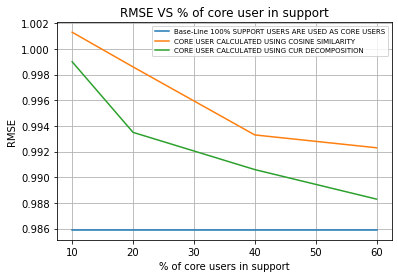

In [62]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60]
y_axis = [1.0013,0.9986,0.9933, 0.9923]
x1_axis = [10, 20, 40, 60]
y1_axis = [0.9859, 0.9859, 0.9859, 0.9859]
x2_axis = [10, 20, 40, 60]
y2_axis = [0.9990, 0.9935, 0.9906, 0.9883]

plt.plot(x1_axis, y1_axis, label="Base-Line 100% SUPPORT USERS ARE USED AS CORE USERS")
plt.plot(x_axis, y_axis, label="CORE USER CALCULATED USING COSINE SIMILARITY")
plt.plot(x2_axis, y2_axis, label="CORE USER CALCULATED USING CUR DECOMPOSITION")

plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend(fontsize=7)
plt.show()